In [1]:
import scanpy as sp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as scp
from scipy.stats import pearsonr

In [8]:
input_file = "/Users/manuel/OneDrive/jupyter_notebooks/scanpy_scRNA-seq_analysis/GSM3017261_150000_CNS_nuclei.h5ad"
sp_dge = sp.read(input_file)

In [9]:
orig = sp_dge

In [10]:
input_file = "/Users/manuel/OneDrive/jupyter_notebooks/scanpy_scRNA-seq_analysis/dge_matrix_umid1_presel.h5ad"
sp_dge_my_d1 = sp.read(input_file)

In [11]:
my = sp_dge_my_d1

### find HVGs of original dataset

In [12]:
sp.pp.normalize_total(sp_dge, target_sum=1e4)
sp.pp.log1p(sp_dge)
sp_dge.raw = sp_dge
sp.pp.highly_variable_genes(sp_dge, min_mean=0.0125, max_mean=3, min_disp=0.5)
sp_dge = sp_dge[:, sp_dge.var.highly_variable]

### correct gene names in original dataset

In [15]:
correct_gene_names(sp_dge)

View of AnnData object with n_obs × n_vars = 156049 × 3442 
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

### find matches between HVG in original and my dataset

In [20]:
matches = find_matches(sp_dge.var_names, sp_dge_my_d1.var_names)

### shorten datasets based on HVGs in original dataset

In [28]:
orig_hvg = subset_var(sp_dge, matches)
my_hvg = subset_var(sp_dge_my_d1, matches)

### linear relationship?

In [51]:
my_hvg_counts = [0]*len(matches)
orig_hvg_counts = [0]*len(matches)

for i in range(len(matches)):
    my_hvg_counts[i] = get_counts_for_gene(my_hvg, index=i)
    orig_hvg_counts[i] = get_counts_for_gene(orig_hvg, index=i)

In [52]:
my_hvg_counts_sorted = [0]*len(matches)
orig_hvg_counts_sorted = [0]*len(matches)

for i in range(len(matches)):
    my_hvg_counts_sorted[i] = sort_counts_ascending(my_hvg_counts[i])
    orig_hvg_counts_sorted[i] = sort_counts_ascending(orig_hvg_counts[i])

In [53]:
my_hvg_counts_casted = [0]*len(matches)
orig_hvg_counts_casted = [0]*len(matches)

for i in range(len(matches)):
    my_hvg_counts_casted[i] = my_hvg_counts_sorted[i][-150000:]
    orig_hvg_counts_casted[i] = orig_hvg_counts_sorted[i][-150000:]

In [54]:
corr = [0]*len(matches)
for i in range(len(my_hvg_counts_casted)):
    cor, conf = pearsonr(my_hvg_counts_casted[i], orig_hvg_counts_casted[i])
    corr[i] = cor

In [57]:
slopes = []
for i in range(len(my_hvg_counts_casted)):
    slopes.append(linear_fit(my_hvg_counts_casted[i], orig_hvg_counts_casted[i], no_cells=150000)[1])

In [58]:
np.std(slopes)

1.267299074182679

In [ ]:
my_hvg_counts = [0]*len(matches)
orig_hvg_counts = [0]*len(matches)

for i in range(len(matches)):
    my_hvg_counts[i] = sort_counts_ascending(get_counts_for_gene(my_hvg, index=i)[i])[i][-150000:]
    orig_hvg_counts[i] = sort_counts_ascending(get_counts_for_gene(orig_hvg, index=i)[i])[i][-150000:]

### Clustering

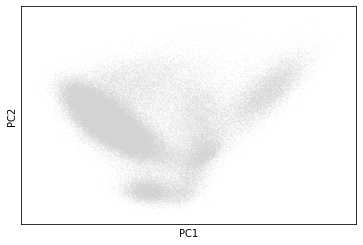

In [31]:
sp.tl.pca(orig_hvg, svd_solver='arpack')
sp.pl.pca(orig_hvg)

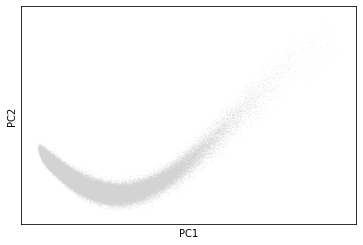

In [32]:
sp.tl.pca(my_hvg, svd_solver='arpack')
sp.pl.pca(my_hvg)

In [59]:
sp.pp.neighbors(orig_hvg, n_neighbors=10, n_pcs=40)
sp.tl.umap(orig_hvg)
sp.tl.leiden(orig_hvg)

KeyboardInterrupt: 

In [ ]:
sp.pp.neighbors(my_hvg, n_neighbors=10, n_pcs=40)
sp.tl.umap(my_hvg)
sp.tl.leiden(my_hvg)

## Functions

In [25]:
def subset_var(anndata_1, sub_genes):
    # an anndata object can be subset based on the genes in the list "sub_genes"
    # returns the subset anndata object
    
    keep = [False]*len(anndata_1.var_names)
    for i in range(len(anndata_1.var_names)):
        if anndata_1.var_names[i] in sub_genes:
            keep[i] = True

    return anndata_1[:, keep]

In [14]:
def correct_gene_names(AnnData_object):
    genes = AnnData_object.var_names.tolist()
    genes_new = []
    for gene in genes:
        genes_new.append(gene.split(" ")[0])
    AnnData_object.var_names = genes_new
    
    return AnnData_object

In [18]:
def no_matches(list1, list2):
    count = 0
    for item in list1:
        if item in list2:
            count += 1
    return count

In [19]:
def find_matches(list1, list2):
    matches = []
    for item in list1:
        if item in list2:
            matches.append(item)
    return matches

In [36]:
def get_counts_for_gene(AnnData_object, gene_name=False, index="false"):
    # you can return the counts for one gene based on the gene name or index in the
    # AnnData_object 
        
    if index == "false":
        index = AnnData_object.var_names.get_loc(gene_name)
    
    return AnnData_object.X[:, index]
    

In [37]:
def sort_counts_ascending(counts):
    counts_list = []
    
    if isinstance(counts, scp.sparse.csc.csc_matrix):
        counts = counts.toarray()  # csc_matrix to ndarray
        counts.sort(axis=0) # sort 1 dimensional array
        for count in counts:
            counts_list.append(count[0])
    else:
        counts.sort(axis=0) # is already a ndarray
        counts_list = counts.tolist()
        
    return counts_list

In [56]:
def linear_fit(y_values, x_values, no_cells):
    # two lists of values for which a linear model should be calculated
    # returns a list containing intercept and slope
    from sklearn.linear_model import LinearRegression
    
    # select a fraction of cells
    y = y_values[-no_cells:]
    x = x_values[-no_cells:]
    
    # reshape 1D np.array to 2D np.array
    y = np.array(y).reshape(-1,1)
    x = np.array(x).reshape(-1, 1)
    
    # fit linear model
    regressor = LinearRegression()
    regressor.fit(y, x)

    return [regressor.intercept_, regressor.coef_[0]]